## Multilayer Network

This file is the network analysis part of the project, submitted to Prof. Soong Moon Kang for MSIN0074 Network Analysis by SRN 22086573.

### Network Building

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from py3plex.core import multinet
from py3plex.algorithms.statistics.basic_statistics import core_network_statistics, identify_n_hubs
from py3plex.algorithms.statistics.topology import plot_power_law
from py3plex.visualization.multilayer import *
from py3plex.visualization.colors import all_color_names,colors_default
from py3plex.core import multinet
from py3plex.algorithms.community_detection import community_wrapper as cw
from collections import Counter
from networkx.algorithms import community
import community.community_louvain as cl
import operator
import matplotlib.patches as mpatches
import community
import random
from py3plex.core import multinet
from py3plex.algorithms.statistics.basic_statistics import core_network_statistics, identify_n_hubs

In [2]:
%store -r coin_keywords top_coins tweet_corpus hashtag_corpus df

In [3]:
# Define unique words from the hashtag corpus and unique cryptocurrencies
unique_words = list(set([word for hashtag in hashtag_corpus for word in hashtag.split()]))
unique_crypto = [coin.lower() for coin in top_coins]

# Create edges between words and cryptocurrencies
word_crypto_edges = []
for tweet in hashtag_corpus:
    tweet_words = tweet.split()
    for crypto in unique_crypto:
        if crypto in tweet:
            for word in tweet_words:
                word_crypto_edges.append((word, crypto))

df_word_coin = pd.DataFrame(word_crypto_edges)
df_word_coin['layer1'] = 1
df_word_coin['layer2'] = 2

# Create edges between words in the hashtag corpus
word_word_edges = []
for tweet in hashtag_corpus:
    tweet_words = tweet.split()
    for i in range(len(tweet_words)-1):
        word_word_edges.append((tweet_words[i], tweet_words[i+1]))

df_word_word = pd.DataFrame(word_word_edges)
df_word_word['layer1'] = 1
df_word_word['layer2'] = 1

# Create edges between cryptocurrencies in the hashtag corpus
crypto_crypto_edges = []
for hashtag in hashtag_corpus:
    hashtag_crypto = [word for word in hashtag.split() if word in unique_crypto]
    for i in range(len(hashtag_crypto)-1):
        crypto_crypto_edges.append((hashtag_crypto[i], hashtag_crypto[i+1]))

df_coin_coin = pd.DataFrame(crypto_crypto_edges)
df_coin_coin['layer1'] = 2
df_coin_coin['layer2'] = 2

# Combine all edges into one DataFrame
df_edge_1 = pd.concat([df_coin_coin, df_word_coin, df_word_word])
df_edge_1['Weight'] = 1

# Rename columns and reindex columns
df_edge_1 = df_edge_1.rename(columns={0: 'From', 1: 'To'})
df_edge_1 = df_edge_1.reindex(columns=['From', 'layer1', 'To', 'layer2', 'Weight'])

# Create a multilayer network object and add edges
A = multinet.multi_layer_network()
A.add_edges(df_edge_1.values.tolist(), input_type="list")

df_edge_1.to_csv("edge_data.csv", index=False)

nx_nodes = list(df_word_word[0].unique()) + list(df_word_word[1].unique())
nx_edges = df_word_word.drop(columns =['layer1', 'layer2'])
nx_edges = nx_edges.values.tolist()

G = nx.Graph()
G.add_nodes_from(nx_nodes)
G.add_edges_from(nx_edges)

### Network Statistics

In [4]:
# Get core network statistics and identify the top hubs
stats_frame = core_network_statistics(A.core_network)
print(stats_frame)

      Name classes nodes   edges     degree     diameter connected components  \
0  example    None  5221  101343  38.821299  intractable                 None   

  clustering coefficient   density  flow_hierarchy  flow hierarchy  
0                   None  0.003719             NaN        0.659079  


### Network Centrality

In [5]:
centralities = A.monoplex_nx_wrapper("degree_centrality")

top_n_by_degree = identify_n_hubs(A.core_network, 20)
print(top_n_by_degree)

{('bitcoin', 2): 11168, ('ethereum', 2): 6308, ('crypto', 1): 5749, ('bitcoin', 1): 5268, ('bnb', 2): 5191, ('usdd', 2): 3746, ('btc', 1): 2812, ('dai', 2): 2759, ('ethereum', 1): 2745, ('xrp', 2): 2642, ('nft', 1): 2627, ('binance', 1): 2291, ('bnb', 1): 2226, ('toncoin', 2): 2224, ('eth', 1): 2184, ('polygon', 2): 2100, ('tron', 2): 2051, ('ecash', 2): 1820, ('cryptocurrency', 1): 1734, ('cardano', 2): 1725}


In [6]:
df = pd.DataFrame.from_dict(centralities, orient='index', columns=['Centrality'])
df.index.name = 'Node'
df = df.sort_values('Centrality', ascending=False)
top_10 = df.head(10)
print(top_10)

               Centrality
Node                     
(bitcoin, 2)     2.139464
(ethereum, 2)    1.208429
(crypto, 1)      1.101341
(bitcoin, 1)     1.009195
(bnb, 2)         0.994444
(usdd, 2)        0.717625
(btc, 1)         0.538697
(dai, 2)         0.528544
(ethereum, 1)    0.525862
(xrp, 2)         0.506130


### Community Detection

In [7]:
# Use the Louvain algorithm to identify communities in the network
partition = community.best_partition(G)

# Set the number of communities to keep
k = 10

# Identify the top k communities by size
partition_counts = dict(Counter(partition.values()))
top_k_communities = sorted(partition_counts, key=partition_counts.get, reverse=True)[:k]

# Create a new partition where nodes in smaller communities are merged into larger ones
new_partition = {}
for node, comm in partition.items():
    if comm in top_k_communities:
        new_partition[node] = comm
    else:
        new_partition[node] = max(top_k_communities)

# Create a new networkx graph object with the reduced number of communities
new_G = nx.Graph()
for node, comm in new_partition.items():
    new_G.add_node(node, community=comm)
for u, v in G.edges():
    if new_partition[u] == new_partition[v]:
        new_G.add_edge(u, v)

# Compute the modularity of the new graph and print the number of communities
modularity = community.modularity(new_partition, new_G)
print(f"Modularity of new graph with {k} communities: {modularity}")
print(f"Number of communities in new graph: {len(set(new_partition.values()))}")

# Compute the degree centrality for each node in the new graph
centrality = nx.degree_centrality(new_G)

Modularity of new graph with 10 communities: 0.7990584098844917
Number of communities in new graph: 10


In [8]:
# Print the top 10 nodes with high centrality in each community
top_nodes_dict = {}
for i, comm in enumerate(top_k_communities, 1):
    nodes_in_comm = [node for node in new_G.nodes() if new_G.nodes[node]['community'] == comm]
    top_nodes = sorted(nodes_in_comm, key=lambda x: centrality[x], reverse=True)[:10]
    top_nodes_dict[i] = top_nodes
    print(f"Community {comm}: {top_nodes}")

Community 3: ['nft', 'nfts', 'nftcommunity', 'tezos', 'giveaway', 'nftart', 'nftgiveaway', 'art', 'nftdrop', 'nftcollection']
Community 1: ['eth', 'btc', 'bnb', 'binance', 'matic', 'xrp', 'doge', 'sol', 'usdt', 'altcoins']
Community 6: ['cryptocurrency', 'cryptonews', 'trading', 'news', 'invest', 'cryptocurrencies', 'money', 'lunc', 'cryptotwitter', 'cryptocurrencymarket']
Community 14: ['blockchain', 'future', 'technology', 'hack', 'tech', 'internet', 'computer', 'developer', 'meme', 'javascript']
Community 2: ['bitcoin', 'ecash', 'xec', 'privacy', 'creditsuisse', 'bankingcrisis', 'fed', 'ordinal', 'mining', 'banking']
Community 8: ['singularitynet', 'toncoin', 'fantom', 'alt', 'conflux', 'altcoin', 'immutablex', 'optimism', 'stack', 'thegraph']
Community 5: ['crypto', 'stpatricksday', 'price', 'exchange', 'svb', 'volt', 'stake', 'crc', 'oscar', 'axie']
Community 12: ['tron', 'polygon', 'arbitrum', 'aptos', 'cosmos', 'magickingdom', 'tronlightcyclerun', 'waltdisneyworld', 'layer2', 'w

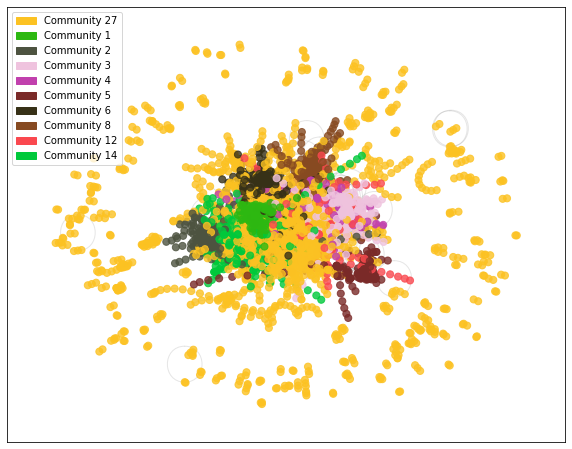

In [9]:
# Define the color map function
def get_random_color():
    """
    Generate a random color in hexadecimal format.
    """
    r = lambda: random.randint(0, 255)
    return '#{:02x}{:02x}{:02x}'.format(r(), r(), r())

# Create a layout for the nodes
pos = nx.spring_layout(new_G)

# Define a color map that maps communities to colors
color_map = {}
for node, comm in new_partition.items():
    if comm not in color_map:
        color_map[comm] = get_random_color()
        
# Set the size of the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(new_G, pos, node_size=50, node_color=[color_map[new_partition[n]] for n in new_G.nodes()], alpha=0.8)
nx.draw_networkx_edges(new_G, pos, edge_color='gray', alpha=0.2)

# Add a legend showing the community colors  
handles = []
for community, color in color_map.items():
    patch = mpatches.Patch(color=color, label='Community {}'.format(community))
    handles.append(patch)
plt.legend(handles=handles)

# Display the graph
plt.show()

### Network Visualisation

-------------------- 
 Network splitting in progress 
 --------------------


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 139.32it/s]


BarnesHut Approximation  took  0.06  seconds
Repulsion forces  took  0.56  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


100%|█████████████████████████████████████████| 100/100 [02:56<00:00,  1.77s/it]


BarnesHut Approximation  took  9.88  seconds
Repulsion forces  took  162.87  seconds
Gravitational forces  took  0.46  seconds
Attraction forces  took  1.97  seconds
AdjustSpeedAndApplyForces step  took  1.38  seconds
Finished with layout..
MultiDiGraph with 71 nodes and 2520 edges
MultiDiGraph with 5150 nodes and 36205 edges


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.12s/it]


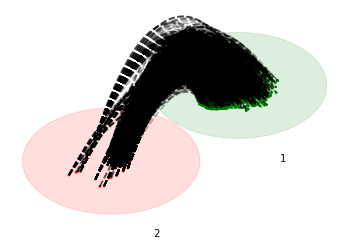

In [23]:
A.visualize_network(style="diagonal")

## Hashtag-Hashtag Layer

In [11]:
# create a networkx graph object
G1 = nx.Graph()

# add nodes and edges to the graph
nx_nodes = list(df_word_word[0].unique()) + list(df_word_word[1].unique())
nx_edges = df_word_word.drop(columns =['layer1', 'layer2'])
nx_edges = nx_edges.values.tolist()
G1.add_nodes_from(nx_nodes)
G1.add_edges_from(nx_edges)

In [12]:
print('Graph with {:.0f} nodes and {:.0f} edges'.format(len(G1.nodes),len(G1.edges)))

Graph with 5144 nodes and 11411 edges


In [13]:
from community import community_louvain as community

# compute the best partition using Louvain method for community detection
partition = community.best_partition(G1)

# set the number of communities to keep
k = 10

# identify the top k communities by size
partition_counts = dict(Counter(partition.values()))
top_k_communities = sorted(partition_counts, key=partition_counts.get, reverse=True)[:k]

# create a new partition where nodes in smaller communities are merged into larger ones
new_partition = {}
for node, comm in partition.items():
    if comm in top_k_communities:
        new_partition[node] = comm
    else:
        new_partition[node] = max(top_k_communities)

# create a new networkx graph object with the reduced number of communities
new_G = nx.Graph()
for node, comm in new_partition.items():
    new_G.add_node(node, community=comm)
for u, v in G.edges():
    if new_partition[u] == new_partition[v]:
        new_G.add_edge(u, v)

# compute the modularity of the new graph and print the number of communities
modularity = community.modularity(new_partition, new_G)
print(f"Modularity of new graph with {k} communities: {modularity}")
print(f"Number of communities in new graph: {len(set(new_partition.values()))}")

# compute the degree centrality for each node in the new graph
centrality = nx.degree_centrality(new_G)

# print the top 10 nodes with high centrality in each community
for comm in top_k_communities:
    nodes_in_comm = [node for node in new_G.nodes() if new_G.nodes[node]['community'] == comm]
    top_nodes = sorted(nodes_in_comm, key=lambda x: centrality[x], reverse=True)[:10]
    print(f"Community {comm}: {top_nodes}")

Modularity of new graph with 10 communities: 0.8018050470391923
Number of communities in new graph: 10
Community 2: ['eth', 'btc', 'bnb', 'cryptocurrency', 'xrp', 'matic', 'sol', 'doge', 'eos', 'stx']
Community 4: ['nft', 'nfts', 'nftcommunity', 'giveaway', 'tezos', 'nftart', 'polygon', 'metaverse', 'nftgiveaway', 'nftcollection']
Community 0: ['crypto', 'cryptonews', 'ai', 'news', 'trading', 'chatgpt', 'cryptotwitter', 'terraclassic', 'cryptocommunity', 'cryptocurrencymarket']
Community 3: ['bitcoin', 'creditsuisse', 'borsa', 'dolar', 'forex', 'kripto', 'forextrader', 'smartcontracts', 'tonblockchain', 'fed']
Community 1: ['ethereum', 'binance', 'airdrop', 'kucoin', 'arbitrum', 'hodl', 'bybit', 'mexc', 'gpt', 'bnbchain']
Community 16: ['dogecoin', 'defi', 'zilliqa', 'chainlink', 'bsc', 'ecash', 'cardano', 'xec', 'hedera', 'cosmos']
Community 13: ['computer', 'hack', 'internet', 'python', 'cybersecurity', 'security', 'meme', 'javascript', 'coding', 'tech']
Community 5: ['singularitynet

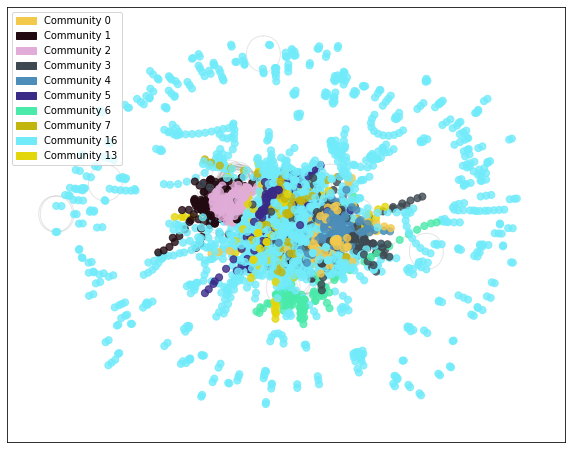

In [14]:
# Create a layout for the nodes
pos = nx.spring_layout(new_G)

# Define a color map that maps communities to colors
color_map = {}
for node, comm in new_partition.items():
    if comm not in color_map:
        color_map[comm] = get_random_color()

# Set the size of the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(new_G, pos, node_size=50, node_color=[color_map[new_partition[n]] for n in new_G.nodes()], alpha=0.8)
nx.draw_networkx_edges(new_G, pos, edge_color='gray', alpha=0.2)
    
# Add a legend showing the community colors  
handles = []
for community, color in color_map.items():
    patch = mpatches.Patch(color=color, label='Community {}'.format(community))
    handles.append(patch)
plt.legend(handles=handles)

# Display the graph
plt.show()

In [15]:
def print_top_centrality_nodes(G):
    # calculate degree centrality
    degree_centrality = nx.degree_centrality(G)
    # print top 10 nodes with highest degree centrality
    sorted_degree = sorted(degree_centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
    print("Top 10 nodes with highest degree centrality:")
    for node in sorted_degree:
        print("Degree centrality of", node[0], ":", node[1])
    print("")

    # calculate closeness centrality
    closeness_centrality = nx.closeness_centrality(G)
    # print top 10 nodes with highest closeness centrality
    sorted_closeness = sorted(closeness_centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
    print("Top 10 nodes with highest closeness centrality:")
    for node in sorted_closeness:
        print("Closeness centrality of", node[0], ":", node[1])
    print("")

    # calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)
    # print top 10 nodes with highest betweenness centrality
    sorted_betweenness = sorted(betweenness_centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
    print("Top 10 nodes with highest betweenness centrality:")
    for node in sorted_betweenness:
        print("Betweenness centrality of", node[0], ":", node[1])
    print("")

In [16]:
print_top_centrality_nodes(G)

Top 10 nodes with highest degree centrality:
Degree centrality of crypto : 0.08496986194827921
Degree centrality of bitcoin : 0.06085942057165079
Degree centrality of nft : 0.056581761617732845
Degree centrality of btc : 0.042387711452459655
Degree centrality of blockchain : 0.04024888197550068
Degree centrality of ethereum : 0.03849893058526152
Degree centrality of eth : 0.03655454015166246
Degree centrality of cryptocurrency : 0.03266575928446432
Degree centrality of web3 : 0.029943612677425627
Degree centrality of nfts : 0.029943612677425627

Top 10 nodes with highest closeness centrality:
Closeness centrality of crypto : 0.3358516762789542
Closeness centrality of nft : 0.3210295618014303
Closeness centrality of bitcoin : 0.32062527240587324
Closeness centrality of ethereum : 0.3119590999140034
Closeness centrality of btc : 0.31133078349927223
Closeness centrality of eth : 0.3109728806011556
Closeness centrality of blockchain : 0.31083887907260005
Closeness centrality of web3 : 0.30

## Crypto-Crypto Layer

In [17]:
nx_nodes2 = list(df_coin_coin[0].unique()) + list(df_coin_coin[1].unique())
nx_edges2 = df_coin_coin.drop(columns =['layer1', 'layer2'])
nx_edges2 = nx_edges2.values.tolist()

G2 = nx.Graph()
G2.add_nodes_from(nx_nodes2)
G2.add_edges_from(nx_edges2)

In [18]:
print('Graph with {:.0f} nodes and {:.0f} edges'.format(len(G2.nodes),len(G2.edges)))

Graph with 63 nodes and 420 edges


In [19]:
print_top_centrality_nodes(G2)

Top 10 nodes with highest degree centrality:
Degree centrality of bitcoin : 0.7258064516129032
Degree centrality of bnb : 0.7096774193548387
Degree centrality of ethereum : 0.6451612903225806
Degree centrality of xrp : 0.5161290322580645
Degree centrality of solana : 0.45161290322580644
Degree centrality of polygon : 0.43548387096774194
Degree centrality of dogecoin : 0.3709677419354839
Degree centrality of cardano : 0.3387096774193548
Degree centrality of neo : 0.3387096774193548
Degree centrality of singularitynet : 0.3225806451612903

Top 10 nodes with highest closeness centrality:
Closeness centrality of bitcoin : 0.759697835851368
Closeness centrality of bnb : 0.7502016129032257
Closeness centrality of ethereum : 0.7060721062618596
Closeness centrality of xrp : 0.6384694577899794
Closeness centrality of solana : 0.6251680107526881
Closeness centrality of polygon : 0.6187229797140007
Closeness centrality of dogecoin : 0.582680864390855
Closeness centrality of cardano : 0.5826808643

In [20]:
# Use the Louvain algorithm to identify communities in the network
communities = cl.best_partition(G2)

# Create a dictionary where the keys are the community IDs and the values are lists of nodes belonging to that community
community_dict = {}
for node, community in communities.items():
    if community not in community_dict:
        community_dict[community] = [node]
    else:
        community_dict[community].append(node)

# Print the nodes in each community
for community, nodes in community_dict.items():
    print(f"Community {community}: {nodes}")

# Print the number of communities found
print(f"Number of communities found: {len(set(communities.values()))}")

Community 0: ['ethereum', 'xrp', 'polkadot', 'dogecoin', 'eos', 'cardano', 'litecoin', 'stellar', 'dash', 'monero', 'zcash', 'quant', 'gatetoken']
Community 1: ['bitcoin', 'tron', 'dai', 'usdd', 'kava', 'zilliqa']
Community 2: ['bnb', 'fantom', 'singularitynet', 'cronos', 'klaytn', 'aptos', 'optimism', 'toncoin', 'gmx', 'magic', 'conflux', 'okb', 'filecoin', 'neo', 'mina', 'loopring', 'immutable', 'dydx', 'casper', 'osmosis']
Community 3: ['polygon', 'solana', 'tezos', 'aave', 'flow', 'apecoin', 'decentraland', 'chiliz', 'pancakeswap', 'thorchain']
Community 5: ['avalanche', 'vechain', 'algorand', 'ecash', 'hedera', 'iota']
Community 4: ['chainlink', 'cosmos', 'uniswap', 'bitdao', 'maker', 'trueusd', 'synthetix']
Community 6: ['multiversx']
Number of communities found: 7


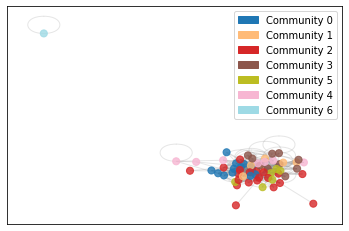

In [21]:
# Create a dictionary to map community IDs to colors
color_map = {}
for community in community_dict.keys():
    color_map[community] = plt.cm.get_cmap('tab20')(community/float(len(set(communities.values()))-1))

# Create a layout for the nodes
pos = nx.spring_layout(G2)

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(G2, pos, node_size=50, node_color=list(communities.values()), cmap=plt.cm.tab20, alpha=0.8)
nx.draw_networkx_edges(G2, pos, edge_color='gray', alpha=0.2)

# Add a legend showing the community colors
handles = []
for community, color in color_map.items():
    patch = mpatches.Patch(color=color, label='Community {}'.format(community))
    handles.append(patch)
plt.legend(handles=handles)

# Display the graph
plt.show()

In [22]:
%store degree_centrality closeness_centrality betweenness_centrality

UsageError: Unknown variable 'degree_centrality'
